# Setup

In [ ]:
import numpy as np
import os
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, \
                    classification_report, confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.svm import SVC

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, ReLU, \
                                        Lambda, GlobalAveragePooling2D, \
                                        Input, Layer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50,ResNet101,ResNet152
from tensorflow.keras.applications.resnet50 import preprocess_input
from keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras import layers, Model, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint


from tqdm.auto import tqdm

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

import pickle

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

# Hyperprameters

In [ ]:
IMAGE_SIZE = 150
BASE_MODEL = ResNet101(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

171446536/171446536 [==============================] - 6s 0us/step


# Loading features

In [ ]:
labeled_data_features = np.load("data/processed/train/features/labeled_data_features.npy")
print("Loaded features", labeled_data_features.shape)

Loaded features (35122, 51200)


In [ ]:
labeled_data = pd.read_csv("data/ext/trainlabels.csv")

labeled_data_labels = labeled_data['level']

print("labeled data labels", len(labeled_data_labels))
print("Class distribution before balancing:", Counter(labeled_data_labels))

labeled data labels 35122
Class distribution before balancing: Counter({0: 25808, 2: 5291, 1: 2442, 3: 873, 4: 708})


# Balancing via SMOTE

In [ ]:
# Set the target number of samples for each class
target_samples = 7000

# Upsample the minority classes (classes 1, 2, 3, and 4) using SMOTE
smote = SMOTE(sampling_strategy={1: 10000, 2: 15000, 3: target_samples, 4: target_samples})
oversampled_features, oversampled_labels = smote.fit_resample(labeled_data_features, labeled_data_labels)

# Downsample the majority class (class 0) using RandomUnderSampler
undersampler = RandomUnderSampler(sampling_strategy={0: 20000})
undersampled_features, undersampled_labels = undersampler.fit_resample(oversampled_features, oversampled_labels)

print("Class distribution after balancing:", Counter(undersampled_labels))
print("Shape of oversampled features:", undersampled_labels.shape)
print("Shape of oversampled labels:", undersampled_labels.shape)

Class distribution after balancing: Counter({0: 20000, 2: 15000, 1: 10000, 3: 7000, 4: 7000})
Shape of oversampled features: (59000,)
Shape of oversampled labels: (59000,)


In [ ]:
os.makedirs('data/processed/train/balanced', exist_ok=True)

np.save("data/processed/train/balanced/features.npy", undersampled_features)
np.save("data/processed/train/balanced/labels.npy", undersampled_labels)

print("Features saved at data/processed/train/balanced/features.npy")
print("Labels saved at data/processed/train/balanced/labels.npy")

Features saved at data/experiments/experiment7/features.npy
Labels saved at data/experiments/experiment7/labels.npy


# Data Split

In [ ]:
undersampled_features = np.load("data/processed/train/balanced/features.npy")
undersampled_labels = np.load("data/processed/train/balanced/labels.npy")

print("Class distribution after balancing:", Counter(undersampled_labels))
print("Shape of oversampled features:", undersampled_labels.shape)
print("Shape of oversampled labels:", undersampled_labels.shape)

Class distribution after balancing: Counter({0: 20000, 2: 15000, 1: 10000, 3: 7000, 4: 7000})
Shape of oversampled features: (59000,)
Shape of oversampled labels: (59000,)


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    undersampled_features, undersampled_labels,
    stratify=undersampled_labels,
    test_size=0.2, random_state=42
)

# Training Classifier on labeled data

In [ ]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

In [ ]:
classifier = Sequential([
    Dense(1024, input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.2),
    ReLU(),

    Dense(512),
    BatchNormalization(),
    Dropout(0.2),
    ReLU(),

    Dense(256),
    BatchNormalization(),
    Dropout(0.2),
    ReLU(),

    Dense(5, activation='softmax')
])

classifier.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = classifier.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val))

Epoch 1/50
1475/1475 [==============================] - 41s 24ms/step - loss: 1.1004 - accuracy: 0.5222 - val_loss: 0.7924 - val_accuracy: 0.6531
Epoch 2/50
1475/1475 [==============================] - 30s 20ms/step - loss: 0.7251 - accuracy: 0.6921 - val_loss: 0.6985 - val_accuracy: 0.7126
Epoch 3/50
1475/1475 [==============================] - 30s 20ms/step - loss: 0.5438 - accuracy: 0.7781 - val_loss: 0.5004 - val_accuracy: 0.7964
Epoch 4/50
1475/1475 [==============================] - 30s 20ms/step - loss: 0.4225 - accuracy: 0.8315 - val_loss: 0.4879 - val_accuracy: 0.8031
Epoch 5/50
1475/1475 [==============================] - 30s 20ms/step - loss: 0.3347 - accuracy: 0.8706 - val_loss: 0.4539 - val_accuracy: 0.8299
Epoch 6/50
1475/1475 [==============================] - 30s 20ms/step - loss: 0.2684 - accuracy: 0.8996 - val_loss: 0.4778 - val_accuracy: 0.8307
Epoch 7/50
1475/1475 [==============================] - 30s 20ms/step - loss: 0.2270 - accuracy: 0.9136 - val_loss: 0.3761 -

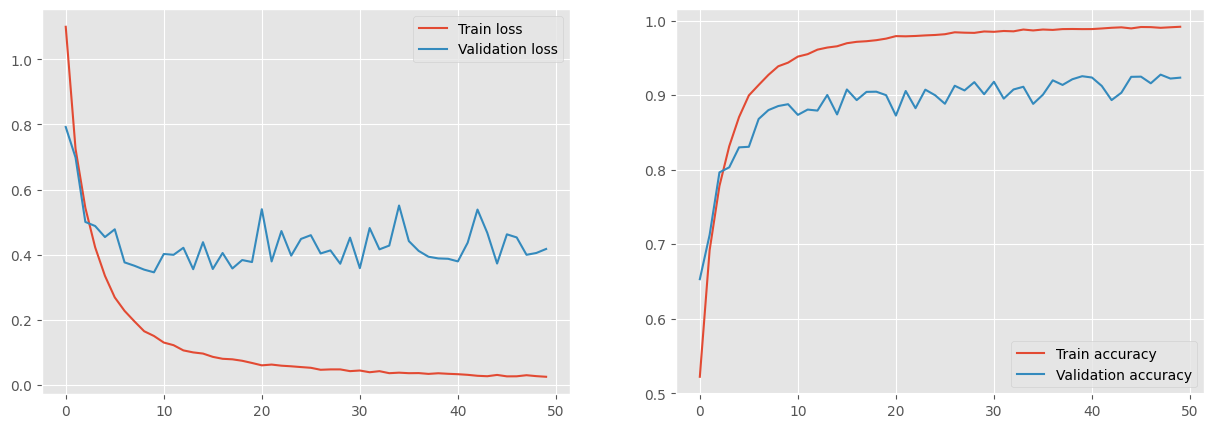

In [ ]:
r = pd.DataFrame(history.history)
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(r.index, r['loss'], label='Train loss')
ax[0].plot(r.index, r['val_loss'], label='Validation loss')
ax[1].plot(r.index, r['accuracy'], label='Train accuracy')
ax[1].plot(r.index, r['val_accuracy'], label='Validation accuracy')
ax[0].legend()
ax[1].legend()
plt.show()

In [ ]:
np.save(f"data/processed/train/balanced/X_train.npy", X_train)
np.save(f"data/processed/train/balanced/y_train.npy", y_train)

np.save(f"data/processed/train/balanced/X_val.npy", X_val)
np.save(f"data/processed/train/balanced/y_val.npy", y_val)

os.makedirs('models/linear', exist_ok=True)
classifier.save(f"models/linear/classifier.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Training KNN Model

In [ ]:
X_train = np.load(f"data/processed/train/balanced/X_train.npy")
y_train = np.load(f"data/processed/train/balanced/y_train.npy")

X_val = np.load(f"data/processed/train/balanced/X_val.npy")
y_val = np.load(f"data/processed/train/balanced/y_val.npy")

In [ ]:
y_train_straight = np.argmax(y_train, axis=1)
y_val_straight = np.argmax(y_val, axis=1)

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train_straight)

print(f"Training Accuracy: {knn.score(X_train, y_train_straight)})")
print(f"Validation Accuracy: {knn.score(X_val, y_val_straight)})")

Training Accuracy: 0.741885593220339)
Validation Accuracy: 0.6695762711864407)


In [ ]:
os.makedirs('models/knn/', exist_ok=True)

pickle.dump(knn, open('models/knn/knn.sav', 'wb'))

# Training Similarity based classifier

In [ ]:
# Load your data

X_train = np.load("data/processed/train/balanced/X_train.npy")
y_train = np.load("data/processed/train/balanced/y_train.npy")
X_val = np.load("data/processed/train/balanced/X_val.npy")
y_val = np.load("data/processed/train/balanced/y_val.npy")

In [ ]:
# Model

# Define the base network to create embeddings
def create_base_network(input_shape):
    input = layers.Input(shape=input_shape)
    x = layers.Dense(128, activation='relu')(input)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(128, activation='relu')(x)
    embedding = layers.Dense(64)(x)  # Embedding size is 64
    return models.Model(input, embedding)

# Distance layer
class DistanceLayer(Layer):
    def __init__(self, num_classes, **kwargs):
        super(DistanceLayer, self).__init__(**kwargs)
        self.num_classes = num_classes

    def build(self, input_shape):
        self.class_prototypes = self.add_weight(shape=(self.num_classes, input_shape[-1]),
                                                initializer='random_normal',
                                                trainable=True)

    def call(self, embeddings):
        expanded_embeddings = tf.expand_dims(embeddings, 1)
        distances = tf.reduce_sum(tf.square(expanded_embeddings - self.class_prototypes), axis=-1)
        return tf.nn.softmax(-distances)

# Define base network
input_shape = X_train.shape[1:]
base_network = create_base_network(input_shape)

# Define inputs
input_a = layers.Input(shape=input_shape)

# Get the embedding for the input
embedding_a = base_network(input_a)

# Define distance layer
distance_layer = DistanceLayer(num_classes=5)(embedding_a)

# Define the model
model = models.Model(input_a, distance_layer)


In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
os.makedirs('models/similarity_based_classifier')

# Define a callback to save the entire model
checkpoint = ModelCheckpoint(
    filepath="models/similarity_based_classifier/sbc.h5",  # Filepath to save the entire model
    monitor='val_accuracy',  # Monitor validation accuracy
    save_best_only=True,  # Save only the best model
    mode='max',  # Save mode based on max validation accuracy
    verbose=1)  # Verbosity level

# Train the model with the callback
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=50,
                    batch_size=128,
                    callbacks=[checkpoint])  # Include the callback in training

Epoch 1/50
366/369 [============================>.] - ETA: 0s - loss: 1.3081 - accuracy: 0.5181
Epoch 1: val_accuracy improved from -inf to 0.61797, saving model to data/experiments/experiment7/sbc.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


369/369 [==============================] - 31s 75ms/step - loss: 1.3048 - accuracy: 0.5188 - val_loss: 0.8645 - val_accuracy: 0.6180
Epoch 2/50
369/369 [==============================] - ETA: 0s - loss: 0.7274 - accuracy: 0.6889
Epoch 2: val_accuracy improved from 0.61797 to 0.72254, saving model to data/experiments/experiment7/sbc.h5
369/369 [==============================] - 7s 18ms/step - loss: 0.7274 - accuracy: 0.6889 - val_loss: 0.6674 - val_accuracy: 0.7225
Epoch 3/50
367/369 [============================>.] - ETA: 0s - loss: 0.5453 - accuracy: 0.7707
Epoch 3: val_accuracy improved from 0.72254 to 0.78195, saving model to data/experiments/experiment7/sbc.h5
369/369 [==============================] - 7s 18ms/step - loss: 0.5445 - accuracy: 0.7712 - val_loss: 0.5220 - val_accuracy: 0.7819
Epoch 4/50
368/369 [============================>.] - ETA: 0s - loss: 0.4134 - accuracy: 0.8310
Epoch 4: val_accuracy improved from 0.78195 to 0.78458, saving model to data/experiments/experiment

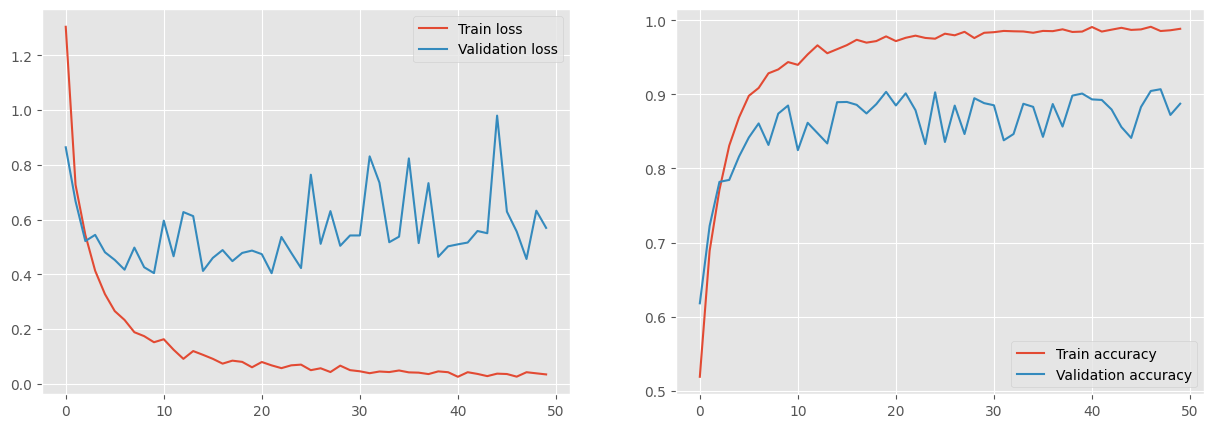

In [ ]:
r = pd.DataFrame(history.history)
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(r.index, r['loss'], label='Train loss')
ax[0].plot(r.index, r['val_loss'], label='Validation loss')
ax[1].plot(r.index, r['accuracy'], label='Train accuracy')
ax[1].plot(r.index, r['val_accuracy'], label='Validation accuracy')
ax[0].legend()
ax[1].legend()
plt.show()

# Loading all three models

In [ ]:
alphas = [0.50, 0.15, 0.35]

classifier = tf.keras.models.load_model(f"models/linear/classifier.h5")
knn = pickle.load(open('models/knn/knn.sav', 'rb'))

# Define custom layer class
class DistanceLayer(tf.keras.layers.Layer):
    def __init__(self, num_classes, **kwargs):
        super(DistanceLayer, self).__init__(**kwargs)
        self.num_classes = num_classes

    def build(self, input_shape):
        self.class_prototypes = self.add_weight(shape=(self.num_classes, input_shape[-1]),
                                                initializer='random_normal',
                                                trainable=True)

    def call(self, embeddings):
        expanded_embeddings = tf.expand_dims(embeddings, 1)
        distances = tf.reduce_sum(tf.square(expanded_embeddings - self.class_prototypes), axis=-1)
        return tf.nn.softmax(-distances)

# Load the model with custom objects scope
custom_objects = {'DistanceLayer': DistanceLayer}
sbc = tf.keras.models.load_model('models/similarity_based_classifier/sbc.h5', custom_objects=custom_objects)


In [ ]:
def combine_predictions(samples, alphas):

  classifier_pred_proba = classifier.predict(samples)
  knn_pred_proba = knn.predict_proba(samples)
  sbc_pred_proba = sbc.predict(samples)

  # Combine predictions with weighted sum
  pred = (alphas[0] * classifier_pred_proba) + (alphas[1] * knn_pred_proba) + (alphas[2] * sbc_pred_proba)

  # Choose the class with the highest combined probability
  pred = np.argmax(pred, axis=1)

  return pred

# Evaluating on Validation set

In [ ]:
X_train = np.load(f"data/processed/train/balanced/X_train.npy")
y_train = np.load(f"data/processed/train/balanced/y_train.npy")

X_val = np.load(f"data/processed/train/balanced/X_val.npy")
y_val = np.load(f"data/processed/train/balanced/y_val.npy")

In [ ]:
y_pred = combine_predictions(X_val, alphas)
y_val_straight = np.argmax(y_val, axis=1)

369/369 [==============================] - 3s 7ms/step


In [ ]:
# Calculate precision, recall, and F1 score
accuracy = accuracy_score(y_val_straight, y_pred)
precision = precision_score(y_val_straight, y_pred, average='weighted')
recall = recall_score(y_val_straight, y_pred, average='weighted')
f1 = f1_score(y_val_straight, y_pred, average='weighted')

# Print the results
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 score:', f1)

Accuracy: 0.9286440677966101
Precision: 0.9285917796622756
Recall: 0.9286440677966101
F1 score: 0.9285052892395228


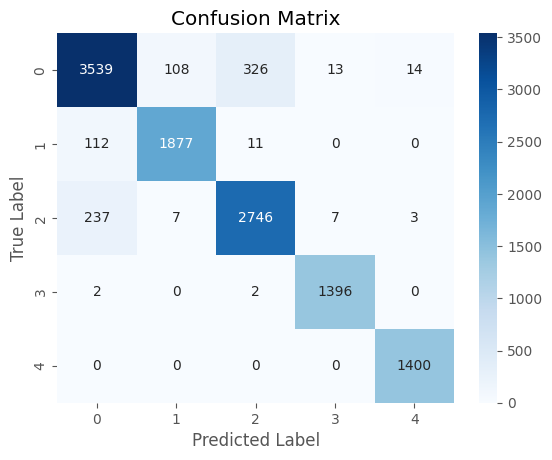

In [ ]:
# Confusion Matrix

cm = confusion_matrix(y_val_straight, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
print(classification_report(y_val_straight, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.88      0.90      4000
           1       0.94      0.94      0.94      2000
           2       0.89      0.92      0.90      3000
           3       0.99      1.00      0.99      1400
           4       0.99      1.00      0.99      1400

    accuracy                           0.93     11800
   macro avg       0.94      0.95      0.95     11800
weighted avg       0.93      0.93      0.93     11800



# Assigning pseudo labels to reliable samples

In [ ]:
reliable_samples = np.load(f"data/sampled/reliable/reliable_samples.npy")

reliable_pseudo_labels = combine_predictions(reliable_samples, alphas=alphas)

np.save(f"data/sampled/reliable/reliable_pseudo_labels.npy", reliable_pseudo_labels)

print('Saving reliable pseudo labels at data/sampled/reliable/reliable_pseudo_labels.npy')

1295/1295 [==============================] - 13s 10ms/step
Saving reliable pseudo labels at data/experiments/experiment7/reliable_pseudo_labels.npy
